# TensorFlow Lite: Model Optimization for On-Device Machine Learning

## Downloading the dataset
By Installing Kaggle In our Colab Notebook and using the kaggle API

**Install the Kaggle library**

In [ ]:
!pip install kaggle






**Make a directory named “.kaggle”**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mzidhssan","key":"3b5a014bb87951830afa8b38e3b8c678"}'}

In [ ]:
!mkdir ~/.kaggle

**Copy the “kaggle.json” into this new directory**

In [ ]:
!cp kaggle.json ~/.kaggle/



**Allocate the required permission for this file.**

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

**Download the Dataset into Colab**

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 91% 135M/149M [00:00<00:00, 228MB/s]
100% 149M/149M [00:00<00:00, 228MB/s]


In [ ]:
!unzip \*.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  

### **About Dataset**
This dataset is a combination of the following three datasets :
*   **figshare**
*   **SRTAJ**
*   **Br35H**

This dataset contains **5712** images of human brain MRI images which are classified into **4 classes**:

1.   **glioma**
2.   **meningioma**
3.   **no tumor**
4.   **pituitary**


no tumor class images were taken from the Br35H dataset.

## Data preprocessing
Import the necessary libraries and packages.



In [ ]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras import layers

%load_ext tensorboard

Let us first define the ***batch_size *** and ***img_size***.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

### **Read Training Data**

In [ ]:
# Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [ ]:
# Create Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Create a function to customize autopct parameter of plt.pie()
def make_autopct(values):
    def my_autopct(pct):
        # The pct is percentage value that matplotlib supplies for every wedge
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.2f}%  ({val})'
    return my_autopct

In [ ]:
cmap = sns.color_palette("Blues")

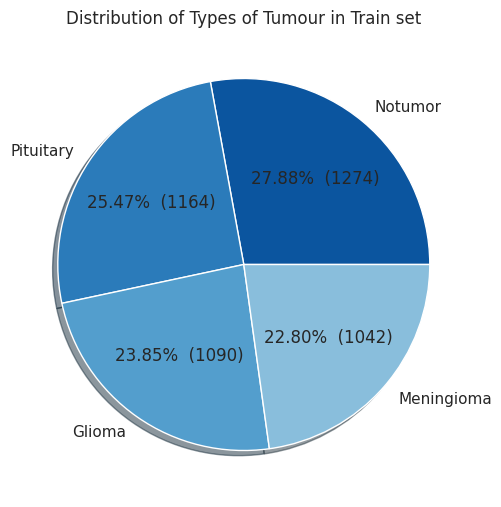

In [ ]:
import pandas as pd

# Visualize Train Dataset
# Count instances in each class of train dataset
train_ds_labels = []

for _, labels in train_ds:
    for i in range(len(labels)):
        train_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': train_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our training data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Train set")
plt.show()


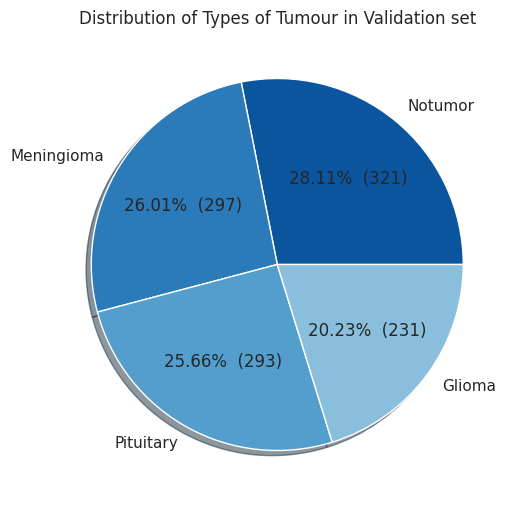

In [ ]:
# Visualize Validation Dataset
# Count instances in each class of validation set
val_ds_labels = []

for _, labels in val_ds:
    for i in range(len(labels)):
        val_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': val_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our validation data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Validation set")
plt.show()

**Inference**: Both, the training set and the validation set have quite equal distribution of instances for each class. Thus, we dont't have to add any additional weigths to a particular class when we train our model.

In [ ]:
def plot_images(n_rows, n_cols, data_set):
    """
    Plots a figure containing all images in paths_img
    along with paths_label

    Parameters:
    n_rows: number of rows to plot in figure
    n_cols: number of cols to plot in figure
    data_set: The dataset of images to plot
            data_set type: tf.data.Dataset
    """
    plt.figure(figsize=(n_cols*2.25, n_rows*2.25))
    for images, labels in train_ds.take(1):
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

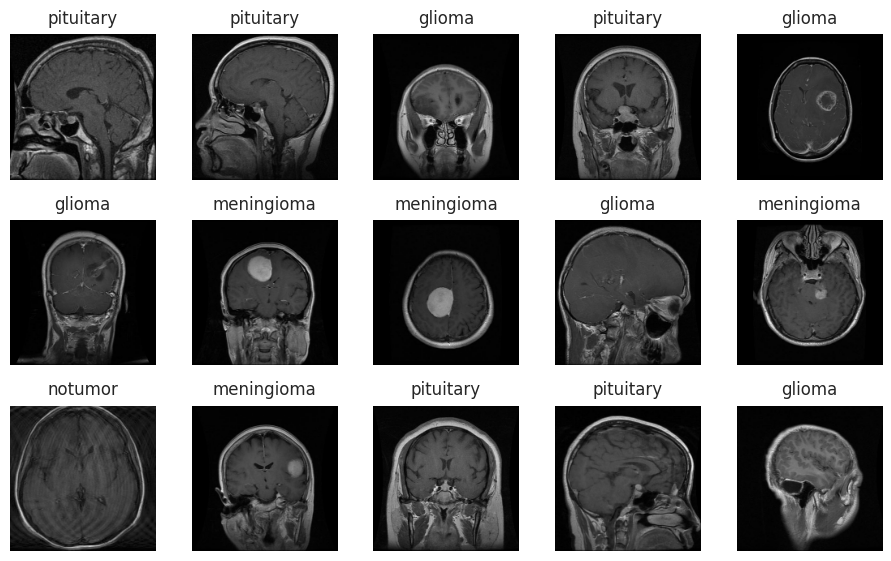

In [ ]:
# View a few Images from Training dataset
plot_images(3, 5, train_ds)

**Autotune performance**

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

1. **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2. **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize data and Data Augmentation**

We will use the Keras preprocessing layers for data augmentation and apply those layers to our model.

The benefit of this approach is:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
* When we export our model using model.save, the preprocessing layers will be saved along with the rest of our model. If we later deploy this model, it will automatically standardize images (according to the configuration of our layers). This can save us from the effort of having to reimplement that logic server-side.

Also, data augmentation is inactive at test time so input images will only be augmented during calls to **Model.fit** (not **Model.evaluate** or **Model.predict**).

In [ ]:
# Now we will scale pixels between range 0 and 1
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Apply some techniques like flip, rotate and zoom
# inorder to increase the quality and amount of data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
def plot_images_augmented(dataset):
    """
    Parameters:
    : dataset - dataset of type `tf.data.Dataset`
                with images to plot
    """
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

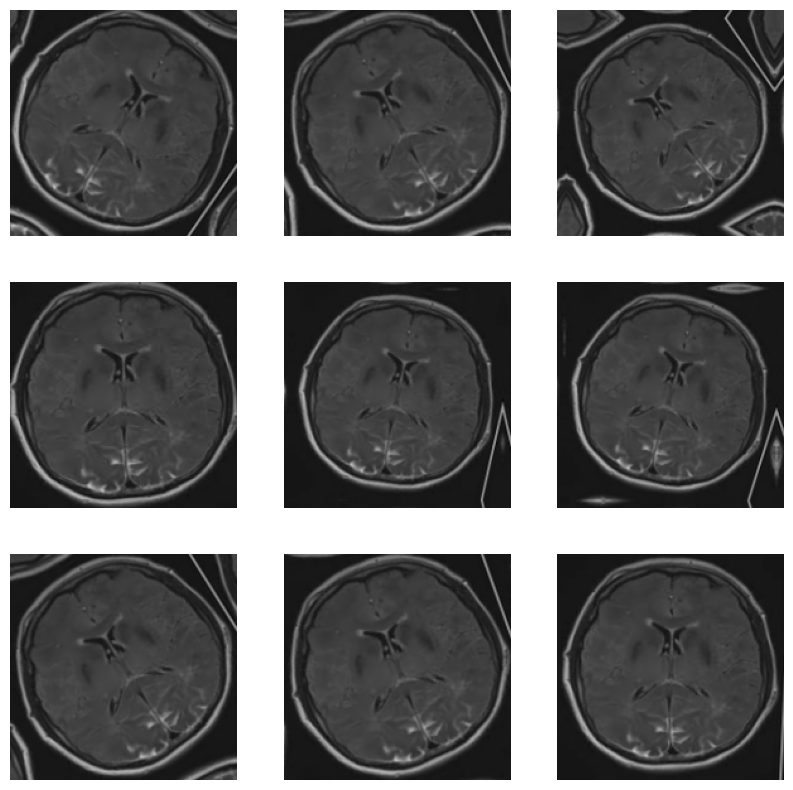

In [ ]:
plot_images_augmented(train_ds)

### Train Model
Apply all data augmentation layers within model.

In [ ]:
# Create model
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile the above model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

About Callbacks to be used:

1. ModelCheckpoint: it will save checkpoints of our model at the end of each epoch and save model whose performance on validation set is best so far (if save_best_model parameter is set True)
2. EarlyStopping: interrupts training when no progress on validation set is made after several epochs (set by patience parameter) and loads back to best model (optionally)

In [ ]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "modelCheckpoint/brainT_detect.h5"
)
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=12,
    restore_best_weights=True
)

In [ ]:
# Fit model with our train data and calc validation score at each epoch
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb,
    ]
)

Epoch 1/100
143/143 [==============================] - 29s 115ms/step - loss: 0.9135 - accuracy: 0.6177 - val_loss: 1.3060 - val_accuracy: 0.5123
Epoch 2/100
143/143 [==============================] - 15s 107ms/step - loss: 0.5904 - accuracy: 0.7687 - val_loss: 0.4965 - val_accuracy: 0.8363
Epoch 3/100
143/143 [==============================] - 15s 105ms/step - loss: 0.4794 - accuracy: 0.8158 - val_loss: 0.9481 - val_accuracy: 0.6515
Epoch 4/100
143/143 [==============================] - 15s 105ms/step - loss: 0.4601 - accuracy: 0.8184 - val_loss: 0.4951 - val_accuracy: 0.8266
Epoch 5/100
143/143 [==============================] - 11s 76ms/step - loss: 0.4040 - accuracy: 0.8446 - val_loss: 0.3734 - val_accuracy: 0.8538
Epoch 6/100
143/143 [==============================] - 15s 106ms/step - loss: 0.3426 - accuracy: 0.8694 - val_loss: 0.2932 - val_accuracy: 0.8888
Epoch 7/100
143/143 [==============================] - 15s 105ms/step - loss: 0.3106 - accuracy: 0.8799 - val_loss: 0.4120 - 

In [ ]:
model.save("brainT_detect.h5")

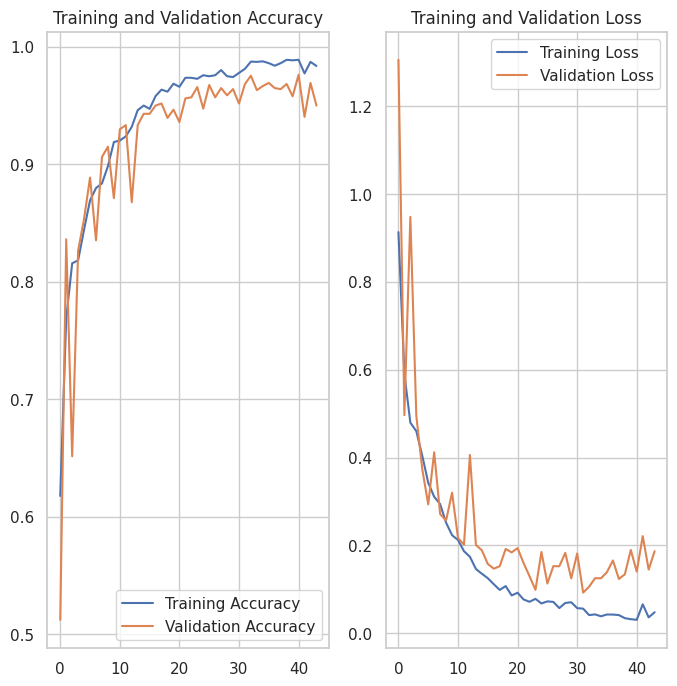

In [ ]:
# Plot the training curves: train and validation accuracy & loss
epochs = len(history.epoch) # epochs completed by early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Read test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1311 files belonging to 4 classes.


In [ ]:
# Evaluating the Model on test dataset.
_, baseline_model_accuracy = model.evaluate(test_ds, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.9649122953414917


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_pred = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred, axis=1)  # Convert predictions to labels

val_true_labels = []  # Ground truth labels
for x, y in val_ds:
    if len(y.shape) > 1:  # Check if y is one-hot encoded
        val_true_labels.extend(np.argmax(y, axis=1))
    else:
        val_true_labels.extend(y)

val_precision = precision_score(val_true_labels, val_pred_labels, average='macro')
val_recall = recall_score(val_true_labels, val_pred_labels, average='macro')
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='macro')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1_score)

36/36 [==============================] - 1s 13ms/step
Validation Precision: 0.9685015092431882
Validation Recall: 0.9667992221818256
Validation F1 Score: 0.96756038718248


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix



# Calculate metrics on validation data after training
val_pred = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred, axis=1)  # Convert predictions to labels

val_true_labels = []  # Ground truth labels
for x, y in val_ds:
    if len(y.shape) > 1:  # Check if y is one-hot encoded
        val_true_labels.extend(np.argmax(y, axis=1))
    else:
        val_true_labels.extend(y)

val_precision = precision_score(val_true_labels, val_pred_labels, average='macro')
val_recall = recall_score(val_true_labels, val_pred_labels, average='macro')
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='macro')
val_confusion_matrix = confusion_matrix(val_true_labels, val_pred_labels)

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1_score)
print("Confusion Matrix:")
print(val_confusion_matrix)

36/36 [==============================] - 1s 14ms/step
Validation Precision: 0.9685015092431882
Validation Recall: 0.9667992221818256
Validation F1 Score: 0.96756038718248
Confusion Matrix:
[[218  12   0   1]
 [  5 280   7   5]
 [  1   1 317   2]
 [  0   2   0 291]]


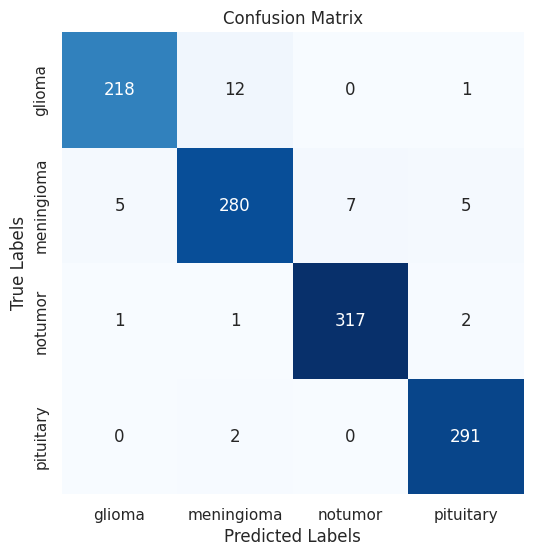

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Replace with your actual class labels
plt.figure(figsize=(8, 6))
sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

36/36 [==============================] - 0s 14ms/step
Validation Precision: 0.9685015092431882
Validation Recall: 0.9667992221818256
Validation F1 Score: 0.96756038718248
Confusion Matrix:
[[218  12   0   1]
 [  5 280   7   5]
 [  1   1 317   2]
 [  0   2   0 291]]


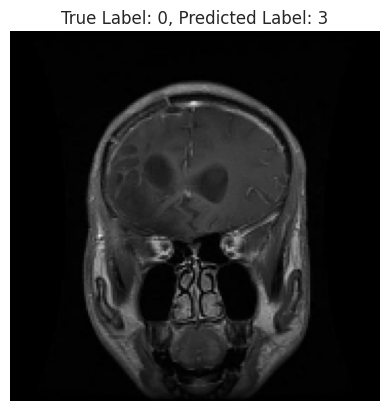

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics on validation data after training
val_pred = model.predict(val_ds)
val_pred_labels = np.argmax(val_pred, axis=1)  # Convert predictions to labels

val_true_labels = []  # Ground truth labels
misclassified_indices = []  # Indices of misclassified images
for i, (x, y) in enumerate(val_ds.take(len(val_pred_labels))):
    if len(y.shape) > 1:  # Check if y is one-hot encoded
        val_true_labels.extend(np.argmax(y, axis=1))
    else:
        val_true_labels.extend(y)
    if val_true_labels[i] != val_pred_labels[i]:
        misclassified_indices.append(i)

val_precision = precision_score(val_true_labels, val_pred_labels, average='macro')
val_recall = recall_score(val_true_labels, val_pred_labels, average='macro')
val_f1_score = f1_score(val_true_labels, val_pred_labels, average='macro')
val_confusion_matrix = confusion_matrix(val_true_labels, val_pred_labels)

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1_score)
print("Confusion Matrix:")
print(val_confusion_matrix)

# Display misclassified images
for idx in misclassified_indices:
    x, y_true = next(iter(val_ds.skip(idx).take(1)))
    y_pred = val_pred_labels[idx]
    # Plot the misclassified image
    plt.imshow(x[0].numpy().astype(np.uint8))  # Assuming the images are in uint8 format
    plt.title(f"True Label: {y_true[0]}, Predicted Label: {y_pred}")
    plt.axis("off")
    plt.show()


In [ ]:
model.save('/content/EfnetB0/efnetb0_saved_model.h5')

In [ ]:
# Function for evaluating TFLite model over test images.
def evaluate(interpreter):
  prediction= []

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']

  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

  print('\n')

  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  accuracy = (prediction == test_labels).mean()
  return accuracy

## Quanttization

Quantization works by reducing the precision of the numbers used to represent a model's parameters, which by default are 32-bit floating-point numbers. This results in a smaller model size and faster computation.

### Float 16 Quantaziation


In Float-16 quantization, weights are converted to 16-bit floating-point values. This results in a 2x reduction in model size. There is a significant reduction in model size in exchange for minimal impacts to latency and accuracy.

In [ ]:
# Passing Keras Model to TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Using float 16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Converting the model
tflite_fp16_model = converter.convert()

# Saving the model.
with open('/content/fp_16_model.tflite', 'wb') as f:
  f.write(tflite_fp16_model)

We have passed the Float 16 quantization to the ***converter.target_spec.supported_type*** to specify the type of quantization. The rest of the code remains the same for a general way of conversion for the TF Lite Model.


Let’s check this Float 16 quantized TF Lite’s model performance on the Test Set.


In [ ]:
# Extracting and saving test images and labels from the test dataset.
test_images = []
test_labels = []
for image, label in test_ds.take(len(test_ds)).unbatch():
  test_images.append(image)
  test_labels.append(label)

In [ ]:
# Passing FP16 TFLite model to the interpreter
interpreter = tf.lite.Interpreter('/content/fp_16_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.


Float 16 Quantized TFLite Model Test Accuracy: 97.17772692601068
Baseline Keras Model Test Accuracy: 97.17772603034973


### Integer Qunatization

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This resulted in a smaller model and increased inferencing speed.

The integer quantization requires a representative dataset, i.e. a few images from the training dataset, for the conversion to happen.


In [ ]:
# Passing the baseline Keras model to TFLite converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Defining the representative dataset from training images.
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(100):
    yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using integer quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Setting the input and output tensors to uint8 (APIs added in r2.3).
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Converting the model.
int_quant_model = converter.convert()

# Saving the integer quantized TFLite model.
with open('/content/int_quant_model.tflite', 'wb') as f:
  f.write(int_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Let’s evaluate the obtained Integer Quantized TF Lite model on Test Dataset.

In [ ]:
# Passing the integer quantized TFLitemodel to the interpreter.
interpreter = tf.lite.Interpreter('/content/int_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on test images.
test_accuracy = evaluate(interpreter)
print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.


Integer Quantized TFLite Model Test Accuracy: 97.25400457665904
Baseline Keras Model Test Accuracy: 97.17772603034973


### Dynamic Range Quantization

In Dynamic Range Quantization, weights are converted to 8-bit precision values. Dynamic range quantization achieves a 4x reduction in the model size.

In [ ]:
# Passing baseline Keras model to TFLite converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Using Dynamic Range quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model.
tflite_quant_model = converter.convert()
# Saving the model.
with open('/content/dynamic_quant_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

Let’s evaluate this TF Lite model on the test dataset.

In [ ]:
# Passing Dynamic Range quantized TFLite model to the interpreter.
interpreter = tf.lite.Interpreter('/content/dynamic_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically  Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', baseline_model_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.
Evaluated on 500 results so far.
Evaluated on 600 results so far.
Evaluated on 700 results so far.
Evaluated on 800 results so far.
Evaluated on 900 results so far.
Evaluated on 1000 results so far.
Evaluated on 1100 results so far.
Evaluated on 1200 results so far.
Evaluated on 1300 results so far.


Dynamically  Quantized TFLite Model Test Accuracy: 97.25400457665904
Baseline Keras Model Test Accuracy: 97.17772603034973


#partie ajouté par ahmed "missclassifed images "


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Load the trained model
model = keras.models.load_model("modelCheckpoint/brainT_detect.h5")

# Create the test dataset
test_dir = '/content/Testing/'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Generate predictions for the test dataset
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Compare predictions with ground truth labels
ground_truth_labels = test_ds.labels
misclassified_indices = np.where(predicted_labels != ground_truth_labels)[0]

# Visualize misclassified images
num_misclassified = len(misclassified_indices)
fig, axs = plt.subplots(1, num_misclassified, figsize=(15, 5))

for i, index in enumerate(misclassified_indices):
    img = test_ds[misclassified_indices[i]][0]  # Get the misclassified image
    label = predicted_labels[misclassified_indices[i]]  # Get the predicted label

    # Denormalize and display the image
    img = img * 255.0
    img = img.astype(int)
    axs[i].imshow(img)
    axs[i].set_title(f"Predicted: {class_names[label]}")

plt.tight_layout()
plt.show()


Found 1311 files belonging to 4 classes.
41/41 [==============================] - 2s 45ms/step


AttributeError: ignored